# Week 4: Image Segmentation
### Date: 26 Oct 2023

Last week you learned about different methods for segmenting an image into regions of interest and coding some algorithms. In this session you will get some more experience coding image segmentation algorithms. Your task will be to code a simple statistical method that uses Region growing or connected components.

In [2]:
import numpy as np
import copy
import cv2
# to visualize the plots within the notebook
%matplotlib inline
# to enable interactive
#%matplotlib ipympl
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import random
from PIL import Image
plt.style.use('default')

## Task 1: Region growing
Region growing is a simple way to segment a region of interest from the background of an image.
It takes in a gray-scale image and produces a binary image as output, where a value of 1 represents the region of interest and a value of 0 represents the background.

The algorithm is:
1. Start from a seed pixel.
2. Add neighbouring pixels that satisfy the criteria defining a region (e.g. similar intensity values, intensity above a threshold).
3. Repeat until we can include no more pixels.

Your task is to write a function in Python that implements the region growing algorithm.
Something like:
```
  segmented_img = region_growing(img, x, y)
```

* img: the image to be segmented
* x: the x-coordinate (j if indexed by numpy array) of the seed pixel
* y: the y-coordinate (i if indexed by numpy array) of the seed pixel
* segmented_img: the binary image output of region growing

**Hint:** This is process basically a **Breadth-first Search (BFS)**, which could be easily implemented it with a **queue** (check out collections.deque in PyThon): 

1. Initialise the queue with the seed pixel. 
2. Every time pop the first element from the queue and add its neighbour pixels to the queue if they satisfy the criteria (e.g. intensity above the threshold).
3. Finish when the queue is empty

In the slide 36 in the lecture slides, you were given a slightly different implementation, where all the neighboring pixels are added to the queue and the check is done when the element is popped from the queue. Think about the difference between these two implementations.

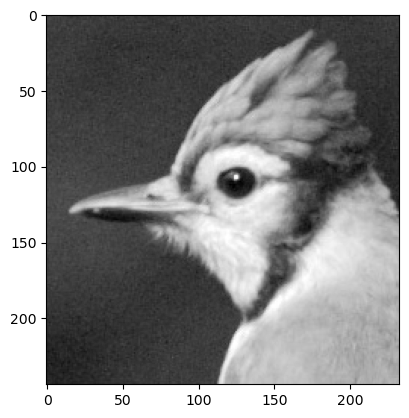

In [3]:
# Load your image
img = cv2.imread('../images/sample_image.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
plt.imshow(gray_img, 'gray')
plt.show()

In [4]:
from collections import deque
def region_growing(img, x, y, thresh=100, connectedness=4):
    '''
    Impelemnt region growing algorithm to segment a gray scaled image into regions
    :param img: gray scaled image [H, W]
    :param x, y: coordinate of the seed pixel
    :param thresh: region growing threshold
    :return: segmented image [H, W]
    '''
    assert img.ndim == 2, "Expect a gray-scale image!!!"
    # Write your own code here
    w, h = img.shape
    seg_img = np.zeros_like(img)
    seed_value = img[x][y]
    if connectedness == 4:
        neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    elif connectedness == 8:
        neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    visited = np.zeros_like(img)
    queue = deque()
    queue.append((x, y))
    seg_img[x][y]= 1
    
    #bfs
    while queue:
        curX, curY = queue.popleft()
        for i, j in neighbors:
            nextX, nextY = curX + i, curY + j
            if 0 <= nextX < w and 0 <= nextY < h and 0 == visited[nextX, nextY]:
                nextValue = img[nextX][nextY]
                if(abs(nextValue - seed_value) <= thresh):
                    seg_img[nextX][nextY]= 1
                    visited[nextX][nextY] = 1
                    queue.append((nextX,nextY))

    return seg_img

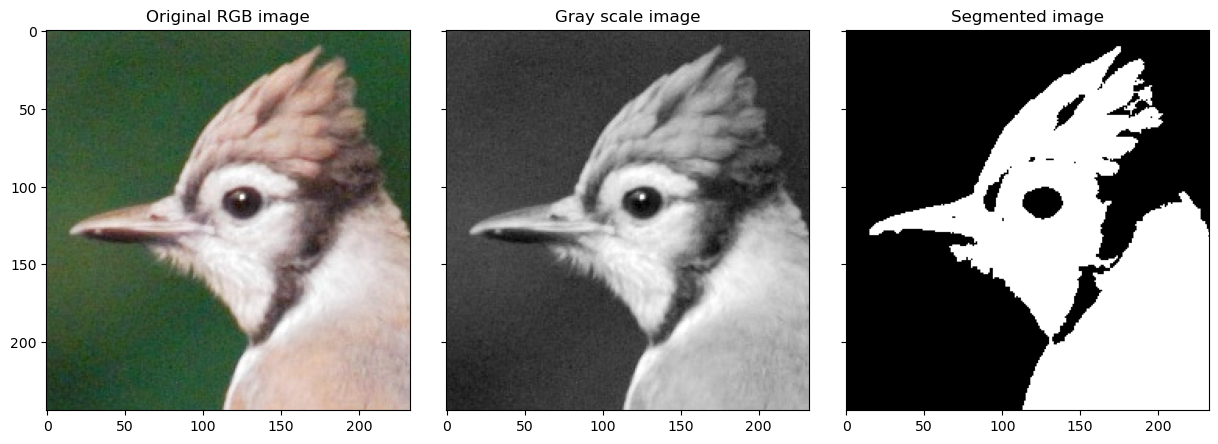

In [5]:
# define set of seed pixel points
x, y = 80, 100

# run region growing algorithm
seg_img = region_growing(gray_img, x, y, thresh=100, connectedness=4)

# Show Original and segmented image
fig, axis = plt.subplots(1, 3, figsize=(15,10), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(img)
axis[0].set_title('Original RGB image')

axis[1].imshow(gray_img, 'gray')
axis[1].set_title('Gray scale image')

axis[2].imshow(seg_img, 'gray')
axis[2].set_title('Segmented image')

plt.show()

### There are two important factors that influence the performance of a region growing algorithm.

#### 1. The first is the seed pixel selection.
Try the following:
1. Pick a random pixel in the image.
2. Plot the histogram of the image, select a reasonable threshold and then search for a pixel whose intensity value is above the threshold (look for the `matplotlib.pyplot.hist()` function).
3. Do it manually (Hint: You can do this by enabling the interactive mode for `matplotlib`).

Which one is better?

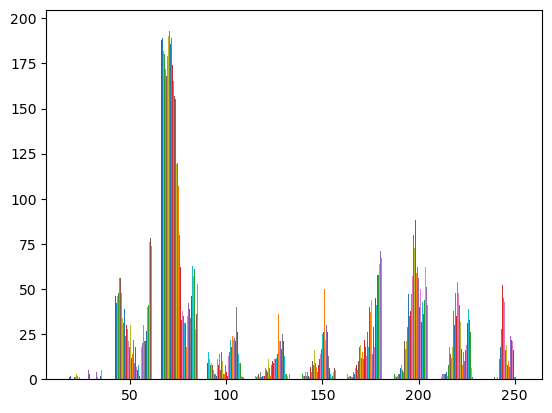

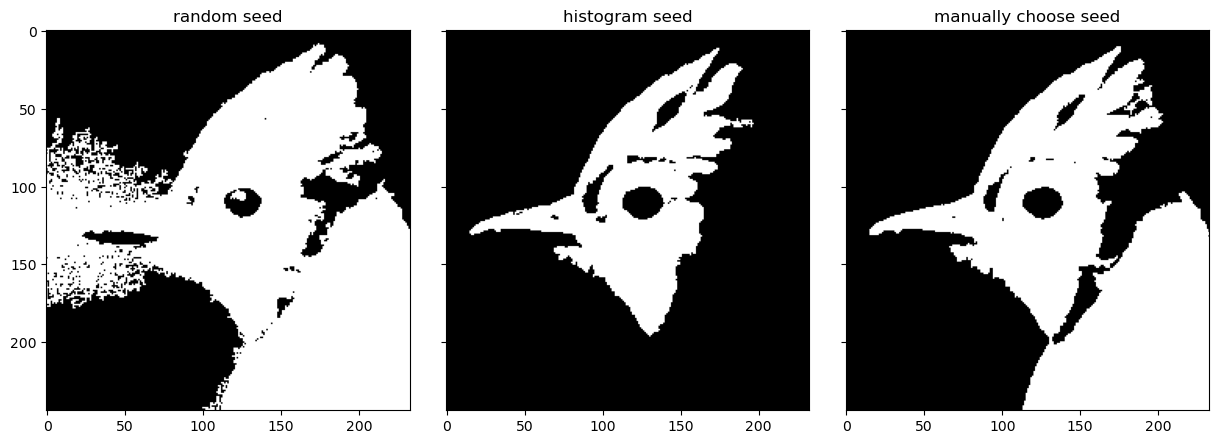

In [6]:
plt.hist(gray_img)
plt.ion()
w, h = gray_img.shape
fig, axis = plt.subplots(1, 3, figsize=(15,10), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)

seg_img_1 = region_growing(gray_img, random.randint(0, w), random.randint(0, h), thresh=100, connectedness=4)
axis[0].imshow(seg_img_1, 'gray')
axis[0].set_title('random seed')

seg_img_2 = region_growing(gray_img, x, y, thresh=80, connectedness=4)
axis[1].imshow(seg_img_2, 'gray')
axis[1].set_title('histogram seed')

seg_img_3 = region_growing(gray_img, 80, 100, thresh=100, connectedness=4)
axis[2].imshow(seg_img_3, 'gray')
axis[2].set_title('manually choose seed')

plt.show()

# The third one is the best strategy.

#### 2. The second important factor is how to decide whether to add a neighbouring pixel to the existing region. 

Again, there are different options. Try the following alternatives:

1. Compare the pixel intensity value of the neighbours to a specified threshold (try the pixel intensity value of the initial seed pixel). If it is larger, then add it to the region. Depending on the seed pixel you might consider adding pixels with smaller intensities or even using a range of valid intensity values.
    
2. Compare the pixel intensity value of the neighbours to the average pixel intensity value of the existing region. How will we decide when to add neighbours to the region in this case?

Which one is better?

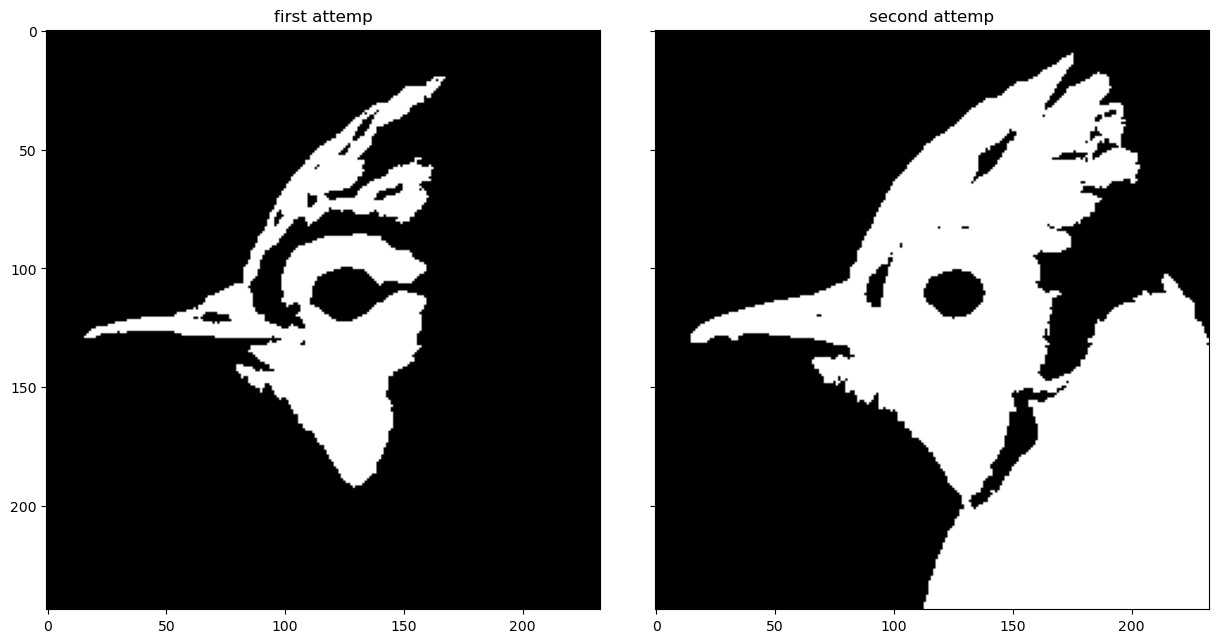

In [7]:
# Write your own code here
## attemp 1
def region_growing_simple(img, x, y, thresh=100, connectedness=4):
    '''
    Impelemnt region growing algorithm to segment a gray scaled image into regions
    :param img: gray scaled image [H, W]
    :param x, y: coordinate of the seed pixel
    :param thresh: region growing threshold
    :return: segmented image [H, W]
    '''
    assert img.ndim == 2, "Expect a gray-scale image!!!"
    # Write your own code here
    w, h = img.shape
    seg_img = np.zeros_like(img)
    seed_value = img[x][y]
    if connectedness == 4:
        neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    elif connectedness == 8:
        neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    visited = np.zeros_like(img, dtype = bool)
    queue = deque()
    queue.append((x, y))
    seg_img[x][y]= 1
    cur_value = seed_value
    cur_num = 1
    
    #bfs
    while queue:
        curX, curY = queue.popleft()
        for i, j in neighbors:
            nextX, nextY = curX + i, curY + j
            if 0 <= nextX < w and 0 <= nextY < h and not visited[nextX, nextY]:
                nextValue = img[nextX][nextY]
                if(nextValue >= seed_value):
                    seg_img[nextX][nextY]= 1
                    visited[nextX][nextY] = True
                    cur_value = (cur_value * cur_num + img[nextX][nextY]) / (cur_num + 1)
                    cur_num += 1
                    queue.append((nextX,nextY))

    return seg_img

## attemp 2
def region_growing_average(img, x, y, thresh=100, connectedness=4):
    '''
    Impelemnt region growing algorithm to segment a gray scaled image into regions
    :param img: gray scaled image [H, W]
    :param x, y: coordinate of the seed pixel
    :param thresh: region growing threshold
    :return: segmented image [H, W]
    '''
    assert img.ndim == 2, "Expect a gray-scale image!!!"
    # Write your own code here
    w, h = img.shape
    seg_img = np.zeros_like(img)
    seed_value = img[x][y]
    if connectedness == 4:
        neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    elif connectedness == 8:
        neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    visited = np.zeros_like(img, dtype = bool)
    queue = deque()
    queue.append((x, y))
    seg_img[x][y]= 1
    cur_value = seed_value
    cur_num = 1
    
    #bfs
    while queue:
        curX, curY = queue.popleft()
        for i, j in neighbors:
            nextX, nextY = curX + i, curY + j
            if 0 <= nextX < w and 0 <= nextY < h and not visited[nextX, nextY]:
                nextValue = img[nextX][nextY]
                if(abs(nextValue - cur_value) <= thresh):
                    seg_img[nextX][nextY]= 1
                    visited[nextX][nextY] = True
                    cur_value = (cur_value * cur_num + img[nextX][nextY]) / (cur_num + 1)
                    cur_num += 1
                    queue.append((nextX,nextY))

    return seg_img


w, h = gray_img.shape
x, y = 80, 100
fig, axis = plt.subplots(1, 2, figsize=(15,10), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)

seg_img_1 = region_growing_simple(gray_img, 100, 100, thresh=100, connectedness=4)
axis[0].imshow(seg_img_1, 'gray')
axis[0].set_title('first attemp')

seg_img_2 = region_growing_average(gray_img, x, y, thresh=80, connectedness=4)
axis[1].imshow(seg_img_2, 'gray')
axis[1].set_title('second attemp')

plt.show()


# the latter one is better

### More things to try out:
1. What kind of connectivity did you use for considering neighbour pixels? If you used 4- connectivity, try 8-connectivity, if you used 8-connectivity then try 4-connectivity.
    Does this change results?
    
2. What if there are multiple regions of interest? Consider using multiple seed points. How will you choose these?

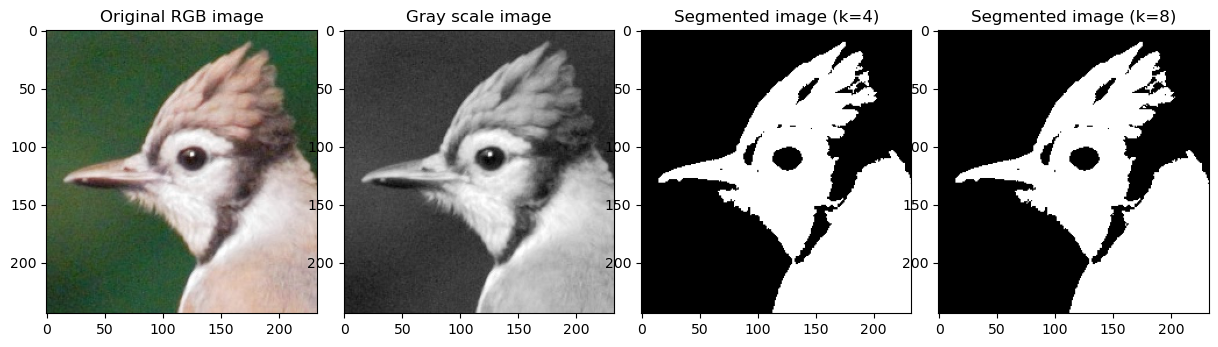

In [8]:
# define set of seed pixel points
x, y = 80, 100

# run region growing algorithm
seg_img = region_growing(gray_img, x, y, thresh=100, connectedness=4)
seg_img2 = region_growing(gray_img, x, y, thresh=100, connectedness=8)

# Show Original and segmented image
fig, axis = plt.subplots(1, 4, figsize=(15,15))
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(img)
axis[0].set_title('Original RGB image')

axis[1].imshow(gray_img, 'gray')
axis[1].set_title('Gray scale image')

axis[2].imshow(seg_img, 'gray')
axis[2].set_title('Segmented image (k=4)')

axis[3].imshow(seg_img2, 'gray')
axis[3].set_title('Segmented image (k=8)')
plt.show()

Question:  
What kind of connectivity did you use for considering neighbour pixels? If you used 4- connectivity, try 8-connectivity, if you used 8-connectivity then try 4-connectivity.Does this change results?  
Answer:  
I tried 8-connectivity above, this doesn`t change results.

Qustion:  
What if there are multiple regions of interest? Consider using multiple seed points. How will you choose these?  
Answer:   
I`ll choose data points which have very different intensity, we can get those datapoints by using the histogram above

## Task 2: Connected Components 

Connected-component labeling (also known as connected-component analysis, or region labeling) is an algorithmic application of graph theory that is used to determine the connectivity of “blob”-like regions in a binary image.
Specifically, the algorithm labels each connected component of a binary image with a separate number.

Similar to Region Growing, for a single connected-component we can start from a seed and iteratively traverse all the neighbouring pixels. In this case,you can perform Depth-first Serach (DFS). Then we just need to repeat this process for all the connected components in the image.

Hint: In the lecture slide you were given as recursive implementation for DFS, but iterative implementation is more efficient.

In [9]:

def connected_components_label(img, connectedness=4):
    # Write your own code here
    if connectedness == 4:
        neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    elif connectedness == 8:
        neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
        
    h, w = img.shape
    label = np.zeros_like(img, dtype = int)
    idx = 0
    for i in range(h):
        for j in range(w):
            if 1 == img[i][j] and 0 == label[i][j]:
                idx +=1
                stack = deque([(i, j)])
                #dfs
                while stack:
                    curX, curY = stack.pop()
                    label[curX][curY] = idx
                    for i, j in neighbors:
                        nextX, nextY = curX + i, curY + j
                        if 0 <= nextX < h and 0 <= nextY < w and 1 == img[nextX][nextY] and 0 == label[nextX][nextY]:
                            stack.append((nextX, nextY))
                    
    return label

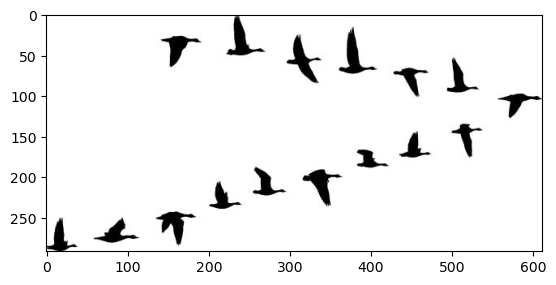

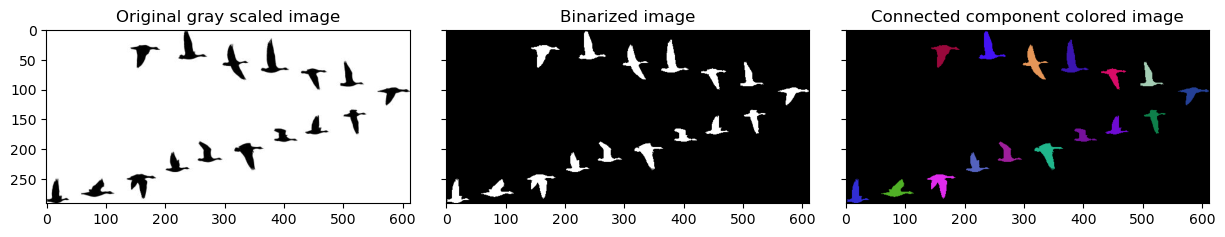

In [10]:
from utils import colourize

img2 = cv2.imread("../images/gooses.jpg")
gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY).astype(np.float32)
plt.imshow(gray_img2, 'gray')

bimg2 = (gray_img2 < 100).astype(np.float32)
ccl_img2 = connected_components_label(bimg2)

fig, axis = plt.subplots(1, 3, figsize=(15,10), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(gray_img2, 'gray')
axis[0].set_title('Original gray scaled image')

axis[1].imshow(bimg2, 'gray')
axis[1].set_title('Binarized image')

axis[2].imshow(colourize(ccl_img2))
axis[2].set_title('Connected component colored image')
plt.show()

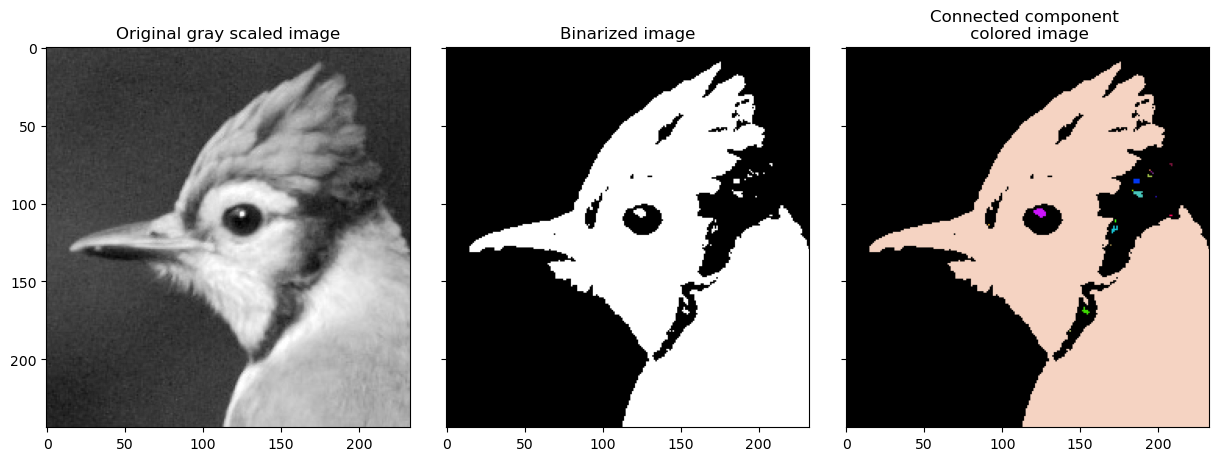

In [11]:
bimg = (gray_img > 100).astype(np.float32)
ccl_img = connected_components_label(bimg)

fig, axis = plt.subplots(1, 3, figsize=(15,10), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.05)
axis[0].imshow(gray_img, 'gray')
axis[0].set_title('Original gray scaled image')

axis[1].imshow(bimg, 'gray')
axis[1].set_title('Binarized image')

axis[2].imshow(colourize(ccl_img))
axis[2].set_title('Connected component \n colored image')
plt.show()